# Does a County's Population Density Impact the Susceptibility to Mental Health Issues among Individuals age 18 and above in the United States? 

## Introduction

**Specific Problem.** How to identify individuals, based on self-administered substance use, demographics, and geographic information from the National Survey on Drug Use and Health (NSDUH), who are more susceptible to mental health issues?  Identify participants with a binary indicator of 1 (Yes) for ‘Past Month Serious Psychologicial Distress Indicator’ which is derived from a series of six questions known as the K6, asking adults respondents how frequently they experienced symptoms of psychological distress during the past 30 days: 

* How often did you feel nervous?
* How often did you feel hopeless?
* How often did you feel restless or fidgety?
* How often did you feel so sad/depressed that nothing could cheer you up?
* How often did you feel that everything was an effort?
* How often did you feel down on yourself, no good or worthless?


**Analytical Context.**
The Statistical Analysis jupyter notebook will proceed as follows: we will (1) explore the relationship of available features with the interested outcome variable (Any_Mental_Illness_Indicator_Past_Year) using logistic regression; (2) discuss feature engineering (if applicable/need); (3) Bivariate Analysis using Chi-Square/Regression; and (4) Multivariate Analysis with Feature Selection (Forward/Backward/Mixed/other methods) to study the importance of other features in relation to our interested outcome variable.

**Hypothesis**
H_0: County's Population Density Type (PDEN10) and Susceptibility to Mental Health (MH) Issues are independent
H_A: County's Population Density Type (PDEN10) and Susceptibility to Mental Health (MH) Issues are not independent

In [167]:
# import libraries we will be using:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import pingouin
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, roc_curve, auc
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Adjust notebook settings to widen the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [142]:
# read in the data
df = pd.read_csv("./Data/nsduh_data_cleaned.csv", header=0)
print(df.shape)
df = df[df['PDEN10']!=3] # remove those records that are not in CBSA's PDEN10 category
print(df.shape)
df = df.drop(['Unnamed: 0'], axis=1)
print(list(df.columns))

(214505, 96)
(197583, 96)
['Id', 'Year', 'Inpatient_Past_Year', 'Outpatient_Past_Year', 'Prescription_Treatment_Past_Year', 'Any_Treatment_Past_Year', 'Treatment_Type_Past_Year', 'Perceived_Unmet_Need', 'Received_Treatment_At_Clinic_Or_Center', 'Received_Treatment_At_Private_Therapist', 'Received_Treatment_At_NonClinic_Doctor', 'Received_Treatment_At_Medical_Clinic', 'Received_Treatment_At_Day_Hospital', 'Received_Treatment_At_School', 'Received_Treatment_Other', 'Self_Paid', 'Non_Household_Member_Paid', 'Private_Health_Insurance_Paid', 'Medicare_Paid', 'Medicaid_Paid', 'Rehab_Paid', 'Employer_Paid', 'Military_Paid', 'Other_Public_Source_Paid', 'Other_Private_Source_Paid', 'Nobody_Paid', 'No_Treatment_Could_Not_Afford', 'No_Treatment_Feared_Neighbors_Opinion', 'No_Treatment_Feared_Effect_On_Job', 'No_Treatment_Insurance_Not_Covered', 'No_Treatment_Insurance_Not_Covered_Enough', 'No_Treatment_Where_To_Go', 'No_Treatment_Confidentiality_Concerns', 'No_Treatment_Fear_Of_Being_Committed', 

In [143]:
df.head()

,Id,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Treatment_Type_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Gender,Age_Category,Age_Category_Two_Levels,Age_Category_Three_Levels,Age_Category_Six_Levels,Gender_Age_Category,Race_Ethnicity,Race_Sex,Education_Category,Overall_Health,Work_Situation_Past_Week,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Adult_Employment_Status,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Total_Income_Family,Participated_In_One_Or_More_Government_Assistance_Programs,Total_Income_Family_Recode,Poverty_Level,PDEN10,County_Metro_NonMetro_Status
0,13005143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,4,3,4,4,5,7,5,2,1,1,0,0,1,0,1,0,0,-1,1,1,0,0,1,0,1,1,2,4,1,2,2,2,2
1,67415143,2015,0,1,1,1,6,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,0,0,11,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,3,3,3,3,5,1,2,4,2,7,0,-1,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,2,3
3,47745143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,8,0,0,0,0,0,0,1,1,1,0,0,0,0,0,-1,1,2,2,2,2,3,5,7,3,3,7,0,-1,4,0,0,0,1,-1,1,1,0,0,0,0,0,0,1,1,0,1,1,1,1
4,33145143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,2,2,2,2,3,7,5,2,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,3,2,2
5,99116143,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,5,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,3,3,3,3,5,1,2,3,1,1,0,1,1,0,0,0,1,-1,1,1,0,0,0,0,0,0,4,7,0,4,3,1,1


In [144]:
df.dtypes

Id                                                                     int64
Year                                                                   int64
Inpatient_Past_Year                                                    int64
Outpatient_Past_Year                                                   int64
Prescription_Treatment_Past_Year                                       int64
Any_Treatment_Past_Year                                                int64
Treatment_Type_Past_Year                                               int64
Perceived_Unmet_Need                                                   int64
Received_Treatment_At_Clinic_Or_Center                                 int64
Received_Treatment_At_Private_Therapist                                int64
Received_Treatment_At_NonClinic_Doctor                                 int64
Received_Treatment_At_Medical_Clinic                                   int64
Received_Treatment_At_Day_Hospital                                     int64

In [145]:
# remove redundant columns
df = df.drop(['Covered_By_Any_Health_Insurance', # there's an imputed version
              'Total_Income_Family',  # there's a recoded version
              'Age_Category_Two_Levels', # keeping the 6-level
              'Age_Category_Three_Levels', # keeping the 6-level
              'Gender_Age_Category', # keeping gender & age group
              'Race_Sex', # keeping the ethnicity & gender
              'Age_Category',
              'Work_Situation_Past_Week',
              'Id'], axis=1) # keeping the 6-level

In [146]:
# transform some of the int64 to category for dummy-variables later 
# - easier interpretation with odds ratio in logistic regression

In [147]:
# Treatment_Type_Past_Year
print(df['Treatment_Type_Past_Year'].unique())
df['Treatment_Type_Past_Year'].replace([0,  6,  3,  4, -1,  5,  2,  7,  1], ['Skipped', 'Outpatient_PrescMed', 'PrescMed_Only', 'In_Outpatient', 'Unknown', 'In_PrescMed', 'Outpatient_Only', 'Inp_Outp_PrescMed', 'Inpatient_Only'], inplace=True)
print(df['Treatment_Type_Past_Year'].unique())

[ 0  6  3  4 -1  5  2  7  1]
['Skipped' 'Outpatient_PrescMed' 'PrescMed_Only' 'In_Outpatient' 'Unknown'
 'In_PrescMed' 'Outpatient_Only' 'Inp_Outp_PrescMed' 'Inpatient_Only']


In [148]:
# Gender
print(df['Gender'].unique())
df['Gender'].replace([1,2], ['Male', 'Female'], inplace=True)
print(df['Gender'].unique())

[1 2]
['Male' 'Female']


In [149]:
# Age_Category_Six_Levels
print(df['Age_Category_Six_Levels'].unique())
df['Age_Category_Six_Levels'].replace([2, 3, 4, 5, 6], ['18-25', '26-34', '35-49', '50-64', '65_And_Above'], inplace=True)
print(df['Age_Category_Six_Levels'].unique())

[4 3 2 5 6]
['35-49' '26-34' '18-25' '50-64' '65_And_Above']


In [150]:
# Race_Ethnicity
print(df['Race_Ethnicity'].unique())
df['Race_Ethnicity'].replace([1, 2, 3, 4, 5, 6, 7], ['White', 'Black', 'Native_American', 'Native_Hawaiian', 'Asian', 'Multiple_Races', 'Hispanic'], inplace=True)
print(df['Race_Ethnicity'].unique())

[7 1 5 4 3 2 6]
['Hispanic' 'White' 'Asian' 'Native_Hawaiian' 'Native_American' 'Black'
 'Multiple_Races']


In [151]:
# Education_Category
print(df['Education_Category'].unique())
df['Education_Category'].replace([1, 2, 3, 4], ['Less_than_HS', 'HS_Grad', 'Some_College_Assoc', 'College_Grad'], inplace=True)
print(df['Education_Category'].unique())

[2 4 3 1]
['HS_Grad' 'College_Grad' 'Some_College_Assoc' 'Less_than_HS']


In [152]:
# Overall_Health
print(df['Overall_Health'].unique())
df['Overall_Health'].replace([-1, 1, 2, 3, 4], ['Unknown', 'Excellent', 'Very_Good', 'Good', 'Fair_Poor'], inplace=True)
print(df['Overall_Health'].unique())

[ 1  2  3  4 -1]
['Excellent' 'Very_Good' 'Good' 'Fair_Poor' 'Unknown']


In [153]:
# Adult_Employment_Status
print(df['Adult_Employment_Status'].unique())
df['Adult_Employment_Status'].replace([1, 2, 3, 4], ['Employed_FullTime', 'Employed_PartTime', 'Unemployed', 'Other'], inplace=True)
print(df['Adult_Employment_Status'].unique())

[1 4 2 3]
['Employed_FullTime' 'Other' 'Employed_PartTime' 'Unemployed']


In [154]:
# Total_Income_Family_Recode
print(df['Total_Income_Family_Recode'].unique())
df['Total_Income_Family_Recode'].replace([1,2,3,4], ['20000orLesser', '20000-49999', '50000-75000', '75000orMore'], inplace=True)
print(df['Total_Income_Family_Recode'].unique())

[2 1 4 3]
['20000-49999' '20000orLesser' '75000orMore' '50000-75000']


In [155]:
# Poverty_Level
print(df['Poverty_Level'].unique())
df['Poverty_Level'].replace([-1, 1, 2, 3], ['College_Dorm', 'In_Poverty', 'Up_to_2x_Poverty', 'More_than_2x_Poverty'], inplace=True)
print(df['Poverty_Level'].unique())

[ 2  1  3 -1]
['Up_to_2x_Poverty' 'In_Poverty' 'More_than_2x_Poverty' 'College_Dorm']


In [156]:
# County_Metro_NonMetro_Status
print(df['County_Metro_NonMetro_Status'].unique())
df['County_Metro_NonMetro_Status'].replace([1, 2, 3], ['Large_Metro', 'Small_Metro', 'Non_Metro'], inplace=True)
print(df['County_Metro_NonMetro_Status'].unique())

[2 3 1]
['Small_Metro' 'Non_Metro' 'Large_Metro']


In [134]:
# PDEN10
print(df['PDEN10'].unique())
df['PDEN10'].replace([1,2], ['1_Mil_Or_More', 'Less_than_1_Mil'], inplace=True)
print(df['PDEN10'].unique())

[2 1]
['Less_than_1_Mil' '1_Mil_Or_More']


# Data Exploration

In [18]:
df['Serious_Psychological_Distress_Indicator_Past_Month'].value_counts()

0    181505
1     16078
Name: Serious_Psychological_Distress_Indicator_Past_Month, dtype: int64

Target class has two classes: 
* 1 (Has indication of serious psychological distress indicator past month) = 16,078 people
* 0 (Has no indication of serious psychological distress indicator past month) = 181,505 people

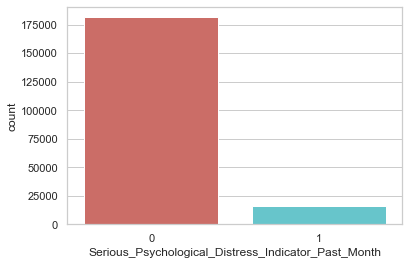

<Figure size 432x288 with 0 Axes>

In [19]:
sns.countplot(x='Serious_Psychological_Distress_Indicator_Past_Month', data=df, palette='hls')
plt.show()
plt.savefig('outcome_plot')

In [20]:
count_no_sub = len(df[df['Serious_Psychological_Distress_Indicator_Past_Month']==0])
count_sub = len(df[df['Serious_Psychological_Distress_Indicator_Past_Month']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of not susceptible to MH issues is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of susceptible to MH issues is", pct_of_sub*100)

percentage of not susceptible to MH issues is 91.86266024911049
percentage of susceptible to MH issues is 8.137339750889499


Our classes are imbalanced, and the ratio of not susceptible to MH issues to susceptible to MH issues is 92:8. Let's do some more exploration before we balance the classes.

In [21]:
df.groupby('Serious_Psychological_Distress_Indicator_Past_Month').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Serious_Psychological_Distress_Indicator_Past_Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2016.975714,0.003245,0.061370,0.099689,0.125368,0.045106,0.008799,0.035294,0.002628,-0.002799,-0.005598,-0.006198,-0.005757,-0.907953,-0.931065,-0.905942,-0.926206,-0.925225,-0.933186,-0.928680,-0.930531,-0.931809,-0.932503,-0.928746,-0.931561,-0.944486,-0.946145,-0.946299,-0.943170,-0.937914,-0.946117,-0.945329,-0.943776,-0.934035,-0.944613,-0.938321,-0.946106,-0.947891,-0.945528,2.566183,5.675948,2.065431,4.769026,0.082064,0.027718,0.001438,-0.003146,0.071981,0.044676,0.095149,0.139825,0.266417,0.006755,0.031107,0.024352,0.112994,0.044831,-0.816407,0.184678,-0.039547,0.109385,0.168739,0.041674,0.652566,-0.828688,0.885546,0.175841,0.059216,0.153792,0.018341,0.028286,0.337539,3.322410,0.190259
1,2017.152196,0.057283,0.279637,0.373741,0.449310,0.385869,0.092984,0.149397,0.038064,0.013248,0.002426,-0.005846,-0.004354,-0.624207,-0.703446,-0.633537,-0.679127,-0.655990,-0.718684,-0.707675,-0.706556,-0.711407,-0.715636,-0.696604,-0.442406,-0.554547,-0.562508,-0.582411,-0.561015,-0.508832,-0.558589,-0.525687,-0.573330,-0.512377,-0.557034,-0.538375,-0.571153,-0.582535,-0.568852,15.245802,59.322553,12.458577,18.459510,1.000000,0.355081,0.130427,0.058714,0.648961,0.229817,0.215698,0.445516,1.932765,0.139818,0.257246,0.117428,0.587635,0.470705,-0.030539,0.624705,-0.245118,0.074512,0.312352,0.044035,0.485633,-0.788158,0.853091,0.168802,0.111892,0.273231,0.039806,0.060020,0.693245,2.233984,0.329083


**Observations:**
* The Inpatient_Past_Year is understandably lower for participants who were not susceptible to MH issues.
* Prescription_Treatment_Past_Year is also understandably higher for participants who were susceptible to MH issues.
* Not surprisingly, participants who were susceptible to MH issues had more serious suicidal thought in the past year. 
* Participants who were not susceptible to MH issues were more likely to have enrolled in Medicare. 

In [22]:
df.groupby('Overall_Health').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Overall_Health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Excellent,2016.968531,0.001716,0.050580,0.068019,0.095318,0.041307,0.003540,0.033988,-0.000391,-0.003258,-0.005190,-0.004952,-0.005560,-0.918864,-0.942210,-0.920189,-0.941580,-0.941189,-0.944425,-0.940625,-0.943513,-0.943491,-0.943860,-0.940060,-0.939322,-0.947618,-0.950962,-0.950962,-0.948551,-0.942232,-0.950593,-0.949420,-0.948313,-0.938844,-0.949138,-0.943882,-0.949681,-0.952982,-0.950919,2.232898,3.524541,0.039113,1.847500,4.483603,0.094340,0.029514,0.004365,-0.000782,0.059093,0.035378,0.077184,0.112561,0.219085,0.006754,0.027190,0.020436,0.097641,0.039786,-0.847913,0.176867,0.018959,0.060613,0.137949,0.034922,0.703818,-0.832190,0.895170,0.119533,0.036789,0.114950,0.013487,0.020784,0.239587,3.452765,0.140859
Fair_Poor,2016.996141,0.026561,0.132304,0.214938,0.252077,0.116504,0.046992,0.053303,0.011396,0.000590,-0.006493,-0.012077,-0.008536,-0.830556,-0.857162,-0.827015,-0.827015,-0.818343,-0.860704,-0.857253,-0.851351,-0.856209,-0.859296,-0.852622,-0.824790,-0.864518,-0.864835,-0.868014,-0.862611,-0.850034,-0.862338,-0.854711,-0.865335,-0.850488,-0.862384,-0.858070,-0.868604,-0.865880,-0.860522,6.200182,34.415936,0.188876,4.496118,8.080953,0.271056,0.099205,0.029694,0.008490,0.241680,0.104154,0.139251,0.243405,0.760136,0.038184,0.082452,0.044268,0.226152,0.149330,-0.590874,0.258978,-0.434098,0.261884,0.339024,0.053939,0.414075,-0.804132,0.856345,0.332804,0.165630,0.317276,0.042770,0.060114,0.788422,2.456799,0.391827
Good,2017.009091,0.009072,0.085070,0.140995,0.168776,0.082161,0.018563,0.04365

In [23]:
df.groupby('Gender').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,2016.979284,0.009601,0.104234,0.159979,0.196142,0.099296,0.021615,0.06248,0.011115,0.000199,-0.003812,-0.005099,-0.004966,-0.851685,-0.887451,-0.848469,-0.879486,-0.873555,-0.891661,-0.885228,-0.889371,-0.889267,-0.890497,-0.884150,-0.856301,-0.885597,-0.887754,-0.889617,-0.882702,-0.871455,-0.88695,-0.882466,-0.885900,-0.866139,-0.885266,-0.872656,-0.888473,-0.891083,-0.887025,4.160736,11.915584,0.094358,3.678122,6.508750,0.186229,0.060739,0.015220,0.004228,0.146452,0.071618,0.119133,0.190751,0.486870,0.019666,0.048404,0.028738,0.187601,0.102030,-0.691015,0.215487,-0.125953,0.108737,0.216244,0.033628,0.626426,-0.845810,0.901262,0.180619,0.068004,0.192888,0.025843,0.037564,0.462767,2.883062,0.231209
Male,2017.002493,0.005388,0.050245,0.078274,0.100622,0.042386,0.008784,0.02398,-0.000936,-0.003440,-0.006248,-0.007402,-0.006422,-0.923043,-0.941417,-0.924403,-0.936725,-0.937563,-0.943430,-0.940002,-0.938695,-0.942189,-0.942886,-0.939436,-0.932556,-0.944007,-0.946195,-0.947839,-0.945869,-0.939294,-0.94638,-0.944225,-0.945542,-0.938369,-0.945074,-0.943887,-0.946805,-0.949319,-0.946924,2.950386,7.884673,0.066432,2.028606,5.163091,0.122849,0.047013,0.008153,-0.000805,0.087266,0.046076,0.088648,0.134724,0.304368,0.015185,0.050779,0.035594,0.110211,0.053544,-0.823161,0.226235,0.023904,0.104029,0.139209,0.051345,0.653430,-0.801892,0.861781,0.169110,0.058322,0.129706,0.013465,0.023163,0.255690,3.637484,0.167434


In [24]:
df.groupby('Overall_Health').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Overall_Health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Excellent,2016.968531,0.001716,0.050580,0.068019,0.095318,0.041307,0.003540,0.033988,-0.000391,-0.003258,-0.005190,-0.004952,-0.005560,-0.918864,-0.942210,-0.920189,-0.941580,-0.941189,-0.944425,-0.940625,-0.943513,-0.943491,-0.943860,-0.940060,-0.939322,-0.947618,-0.950962,-0.950962,-0.948551,-0.942232,-0.950593,-0.949420,-0.948313,-0.938844,-0.949138,-0.943882,-0.949681,-0.952982,-0.950919,2.232898,3.524541,0.039113,1.847500,4.483603,0.094340,0.029514,0.004365,-0.000782,0.059093,0.035378,0.077184,0.112561,0.219085,0.006754,0.027190,0.020436,0.097641,0.039786,-0.847913,0.176867,0.018959,0.060613,0.137949,0.034922,0.703818,-0.832190,0.895170,0.119533,0.036789,0.114950,0.013487,0.020784,0.239587,3.452765,0.140859
Fair_Poor,2016.996141,0.026561,0.132304,0.214938,0.252077,0.116504,0.046992,0.053303,0.011396,0.000590,-0.006493,-0.012077,-0.008536,-0.830556,-0.857162,-0.827015,-0.827015,-0.818343,-0.860704,-0.857253,-0.851351,-0.856209,-0.859296,-0.852622,-0.824790,-0.864518,-0.864835,-0.868014,-0.862611,-0.850034,-0.862338,-0.854711,-0.865335,-0.850488,-0.862384,-0.858070,-0.868604,-0.865880,-0.860522,6.200182,34.415936,0.188876,4.496118,8.080953,0.271056,0.099205,0.029694,0.008490,0.241680,0.104154,0.139251,0.243405,0.760136,0.038184,0.082452,0.044268,0.226152,0.149330,-0.590874,0.258978,-0.434098,0.261884,0.339024,0.053939,0.414075,-0.804132,0.856345,0.332804,0.165630,0.317276,0.042770,0.060114,0.788422,2.456799,0.391827
Good,2017.009091,0.009072,0.085070,0.140995,0.168776,0.082161,0.018563,0.04365

In [25]:
df.groupby('Race_Ethnicity').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Race_Ethnicity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Asian,2017.043789,0.001861,0.032719,0.032524,0.053487,0.036932,-0.001274,0.017535,-0.005682,-0.006270,-0.008229,-0.007641,-0.008817,-0.945631,-0.959444,-0.943476,-0.958170,-0.957386,-0.960031,-0.956799,-0.958954,-0.959346,-0.959346,-0.954839,-0.937892,-0.945533,-0.950235,-0.949843,-0.947100,-0.938578,-0.950333,-0.948472,-0.948276,-0.938871,-0.948472,-0.943966,-0.949745,-0.951998,-0.950235,2.333170,5.651254,0.054369,2.277038,5.324745,0.114028,0.033013,0.002547,-0.002547,0.074745,0.044181,0.086795,0.130976,0.266850,0.007935,0.025862,0.017927,0.092085,0.043201,-0.853252,0.178487,-0.103056,0.054663,0.119906,0.021650,0.762245,-0.854330,0.932504,0.121963,0.034581,0.066321,0.006563,0.010972,0.117065,3.502743,0.091987
Black,2016.993076,0.008847,0.043157,0.056581,0.081314,0.047157,0.009962,0.012655,-0.005039,-0.005347,-0.008962,-0.010462,-0.009424,-0.938803,-0.947457,-0.937303,-0.939418,-0.933956,-0.948111,-0.944727,-0.944727,-0.946804,-0.947842,-0.942996,-0.927456,-0.939457,-0.940265,-0.942149,-0.941111,-0.932341,-0.939534,-0.937187,-0.939880,-0.932226,-0.941072,-0.937418,-0.942034,-0.942149,-0.940572,2.279675,11.583314,0.083237,2.307331,5.427302,0.136126,0.039311,0.004885,-0.001577,0.089507,0.049042,0.091199,0.140242,0.310678,0.011732,0.039118,0.027387,0.091661,0.049965,-0.845065,0.304562,-0.117163,0.100854,0.319025,0.042080,0.472190,-0.786753,0.859682,0.186707,0.117624,0.325640,0.043234,0.065159,0.802793,2.650012,0.379722
Hispanic,2017.007993,0.005891,0.043920,0.060154,0.082640,0.053129,0.006251,0.0192

In [26]:
df.groupby('Age_Category_Six_Levels').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Age_Category_Six_Levels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18-25,2016.984098,0.010611,0.078293,0.103899,0.139731,0.107543,0.014241,0.044198,0.000830,-0.004306,-0.006490,-0.006198,-0.008304,-0.881230,-0.908128,-0.886259,-0.909373,-0.905652,-0.915602,-0.913264,-0.914448,-0.913695,-0.914264,-0.904683,-0.842722,-0.866928,-0.874664,-0.878047,-0.873587,-0.854271,-0.872557,-0.864329,-0.869512,-0.848166,-0.869343,-0.862161,-0.872234,-0.878847,-0.876555,4.367566,10.616809,0.130888,4.330750,7.741915,0.239769,0.092949,0.024298,0.008212,0.141069,0.068651,0.114248,0.182899,0.468804,0.025113,0.069850,0.044737,0.183222,0.112526,-0.715171,0.296624,-0.161692,0.008966,0.226528,0.031511,0.588943,-0.773610,0.864468,0.088304,0.052134,0.178900,0.024206,0.035894,0.393679,1.946328,0.214564
26-34,2016.975434,0.006711,0.085652,0.123592,0.154330,0.083693,0.017880,0.048031,0.008181,-0.000367,-0.004654,-0.006834,-0.005242,-0.874057,-0.906706,-0.875723,-0.901367,-0.892084,-0.908935,-0.900607,-0.905163,-0.906731,-0.908225,-0.904036,-0.872171,-0.902934,-0.902493,-0.903424,-0.896958,-0.887847,-0.903571,-0.900877,-0.903620,-0.888214,-0.902861,-0.891325,-0.906167,-0.907686,-0.903155,3.802293,9.712109,0.078941,3.173533,6.180219,0.165499,0.050921,0.009454,0.000098,0.140296,0.071642,0.119697,0.191339,0.468943,0.021211,0.060939,0.039728,0.160258,0.081096,-0.742211,0.258524,0.071128,0.016606,0.201479,0.032625,0.605491,-0.789164,0.843294,0.074214,0.054472,0.201185,0.024444,0.036960,0.439012,3.516827,0.229720
35-49,2017.003836,0.006905,0.087941,0.144792,0.173178,0.058250,0.018720,0.0515

In [27]:
df.groupby('County_Metro_NonMetro_Status').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
County_Metro_NonMetro_Status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Large_Metro,2016.989671,0.007138,0.077718,0.109119,0.140643,0.070290,0.012680,0.046608,0.004444,-0.002849,-0.005056,-0.006786,-0.006371,-0.884075,-0.913403,-0.882790,-0.908306,-0.907063,-0.916739,-0.911228,-0.914097,-0.914740,-0.916024,-0.911300,-0.895450,-0.915527,-0.917609,-0.919049,-0.913331,-0.904256,-0.917765,-0.914077,-0.915890,-0.902671,-0.915786,-0.907892,-0.918573,-0.920510,-0.917081,3.382645,9.064976,0.077138,2.810086,5.722754,0.149894,0.049737,0.009282,0.000694,0.110921,0.057092,0.103773,0.160865,0.379444,0.016897,0.048918,0.032022,0.142601,0.073015,-0.767249,0.232389,-0.053280,0.093973,0.179440,0.031307,0.645916,-0.823657,0.881734,0.159384,0.061070,0.154577,0.021134,0.028500,0.365542,3.368484,0.191333
Non_Metro,2016.980989,0.008649,0.075422,0.137052,0.162336,0.070162,0.018894,0.037010,0.008454,0.000974,-0.004402,-0.005571,-0.004324,-0.895321,-0.917761,-0.894581,-0.907671,-0.902801,-0.920215,-0.916436,-0.916709,-0.918345,-0.919241,-0.914527,-0.897425,-0.916319,-0.918111,-0.920838,-0.917566,-0.909151,-0.916826,-0.914605,-0.917566,-0.904632,-0.916475,-0.911372,-0.919280,-0.921345,-0.918306,3.844754,11.837859,0.089174,2.984339,6.059605,0.166349,0.060579,0.016752,0.003818,0.129144,0.063033,0.105107,0.168141,0.429506,0.018505,0.049320,0.030815,0.159375,0.087070,-0.739569,0.192138,-0.083252,0.130352,0.191164,0.046165,0.625073,-0.825354,0.883946,0.206397,0.072383,0.181893,0.020336,0.033387,0.375472,3.032646,0.224512
Small_Metro,2016.993686,0.007946,0.082204,0.133340,0.162311,0.0

In [28]:
df.groupby('Total_Income_Family_Recode').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
Total_Income_Family_Recode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000-49999,2016.960938,0.008115,0.067152,0.111980,0.137392,0.073837,0.014817,0.033198,0.003055,-0.002612,-0.006061,-0.007523,-0.006176,-0.902525,-0.923929,-0.903888,-0.916192,-0.913317,-0.926754,-0.923058,-0.922795,-0.924618,-0.925883,-0.921005,-0.881778,-0.911050,-0.911625,-0.912906,-0.908898,-0.898500,-0.911477,-0.907173,-0.911559,-0.898763,-0.910525,-0.905219,-0.913383,-0.915715,-0.912249,3.617277,11.044927,0.090790,2.995138,6.060565,0.168487,0.057969,0.012123,0.001823,0.125959,0.062454,0.108021,0.170475,0.423444,0.018907,0.052319,0.033412,0.150944,0.081837,-0.752550,0.231976,-0.153588,0.128324,0.230251,0.044762,0.524057,-0.762110,0.828047,0.212938,0.071768,0.203903,0.018874,0.031983,0.353138,2.598255,0.253626
20000orLesser,2016.881128,0.017301,0.092136,0.132163,0.166328,0.092290,0.030258,0.035914,0.001260,-0.003702,-0.008021,-0.010026,-0.010592,-0.879637,-0.891668,-0.881000,-0.877889,-0.867092,-0.899355,-0.898301,-0.896964,-0.895499,-0.898044,-0.888146,-0.862593,-0.886809,-0.891951,-0.893159,-0.891411,-0.876218,-0.890049,-0.883802,-0.888943,-0.874341,-0.889072,-0.882619,-0.892234,-0.892439,-0.890820,4.342014,20.098229,0.130260,3.729350,7.110723,0.218129,0.076814,0.018612,0.003933,0.158462,0.074244,0.119129,0.193373,0.520270,0.027070,0.068562,0.041492,0.164786,0.103550,-0.716959,0.224633,-0.449754,0.130903,0.400936,0.029641,0.335253,-0.726523,0.812386,0.188848,0.142292,0.413661,0.061390,0.083987,1.082187,1.366796,0.463765
50000-75000,2017.001074,0.004003,0.076715,0.122250,0.148971

In [29]:
df.groupby('PDEN10').mean()

,Year,Inpatient_Past_Year,Outpatient_Past_Year,Prescription_Treatment_Past_Year,Any_Treatment_Past_Year,Perceived_Unmet_Need,Received_Treatment_At_Clinic_Or_Center,Received_Treatment_At_Private_Therapist,Received_Treatment_At_NonClinic_Doctor,Received_Treatment_At_Medical_Clinic,Received_Treatment_At_Day_Hospital,Received_Treatment_At_School,Received_Treatment_Other,Self_Paid,Non_Household_Member_Paid,Private_Health_Insurance_Paid,Medicare_Paid,Medicaid_Paid,Rehab_Paid,Employer_Paid,Military_Paid,Other_Public_Source_Paid,Other_Private_Source_Paid,Nobody_Paid,No_Treatment_Could_Not_Afford,No_Treatment_Feared_Neighbors_Opinion,No_Treatment_Feared_Effect_On_Job,No_Treatment_Insurance_Not_Covered,No_Treatment_Insurance_Not_Covered_Enough,No_Treatment_Where_To_Go,No_Treatment_Confidentiality_Concerns,No_Treatment_Fear_Of_Being_Committed,No_Treatment_Didnt_Think_Needed,No_Treatment_Handle_Problem_Without,No_Treatment_Didnt_Think_Would_Help,No_Treatment_Didnt_Have_Time,No_Treatment_Didnt_Want_Others_To_Know,No_Treatment_No_Transport_Inconvenient,No_Treatment_Other,Num_Weeks_Mental_Health_Difficulties,Num_Days_Past_Year_Unable_To_Work,Serious_Psychological_Distress_Indicator_Past_Month,Psychological_Distress_Level_Worst_Month,Worst_Psychological_Distress_Level,Serious_Psychological_Distress_Indicator_Past_Year,Serious_Suicidal_Thoughts_Past_Year,Suicide_Plan_Past_Year,Suicide_Attempt_Past_Year,Serious_Or_Moderate_Mental_Illness_Indicator_Past_Year,Moderate_Mental_Illness_Indicator_Past_Year,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_Year,Categorical_Mental_Illness_Indicator,Serious_Mental_Illness_And_Substance_Abuse,Any_Mental_Illness_And_Substance_Abuse,Low_Or_Moderate_Mental_Illness_And_Substance_Abuse,Adult_Lifetime_Major_Depressive_Episode,Adult_Past_Year_Major_Depressive_Episode,Adult_Received_Counseling_Or_Meds_For_Depressive_Feelings_Past_Year,Num_Days_Skipped_Work_Past_30_Days,EAP_Offered,Has_Medicare,Has_Medicaid_Or_CHIP,Has_Military_Benefit,Has_Private_Health_Insurance,Has_Other_Health_Insurance,Covered_By_Any_Health_Insurance_Imputation_Revised,Family_Receives_Social_Security,Family_Receives_SSI,Family_Receives_Food_Stamps,Family_Receives_Public_Assistance,Family_Receives_Welfare_JobPlacement_Childcare,Months_On_Welfare,Total_Income_Respondent,Participated_In_One_Or_More_Government_Assistance_Programs
PDEN10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1_Mil_Or_More,2016.987595,0.007007,0.076631,0.107517,0.138984,0.069843,0.012416,0.045919,0.004029,-0.002945,-0.005255,-0.007007,-0.006569,-0.885147,-0.914249,-0.884194,-0.909552,-0.908128,-0.917676,-0.912245,-0.915059,-0.915694,-0.916964,-0.912234,-0.895712,-0.916077,-0.917960,-0.919296,-0.913581,-0.90445,-0.918190,-0.914435,-0.916296,-0.903245,-0.916252,-0.908380,-0.918880,-0.920840,-0.917457,3.362537,8.975551,0.076828,2.800436,5.705148,0.149167,0.049182,0.009120,0.000602,0.110189,0.056923,0.103335,0.160258,0.376979,0.016653,0.048503,0.031850,0.141338,0.072175,-0.769056,0.233922,-0.054897,0.093251,0.179605,0.031062,0.644251,-0.822071,0.880209,0.158079,0.060689,0.154608,0.021164,0.028182,0.362297,3.365866,0.191068
Less_than_1_Mil,2016.992207,0.008188,0.081281,0.134430,0.162684,0.075408,0.018428,0.043426,0.006786,-0.000245,-0.004678,-0.005449,-0.004847,-0.884620,-0.911077,-0.883415,-0.903133,-0.899180,-0.914060,-0.909364,-0.909938,-0.912310,-0.913044,-0.907811,-0.888357,-0.909900,-0.912319,-0.914446,-0.910776,-0.90175,-0.911482,-0.908385,-0.911340,-0.896695,-0.910343,-0.903538,-0.912771,-0.915858,-0.912658,3.800346,10.957543,0.085281,3.006334,6.036010,0.163286,0.058805,0.014353,0.002993,0.126448,0.062165,0.106354,0.168519,0.423533,0.018381,0.050372,0.031991,0.160453,0.085770,-0.738190,0.208934,-0.057459,0.117978,0.181131,0.051153,0.634453,-0.828243,0.885222,0.190044,0.065921,0.171164,0.019163,0.033177,0.370083,3.120349,0.210571


# Visualizations

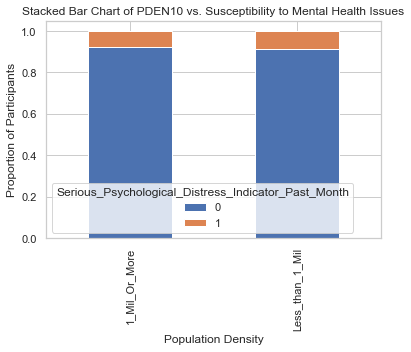

In [30]:
table=pd.crosstab(df.PDEN10,df.Serious_Psychological_Distress_Indicator_Past_Month)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of PDEN10 vs. Susceptibility to Mental Health Issues')
plt.xlabel('Population Density')
plt.ylabel('Proportion of Participants')
plt.savefig('outcome_pden10_stacked')

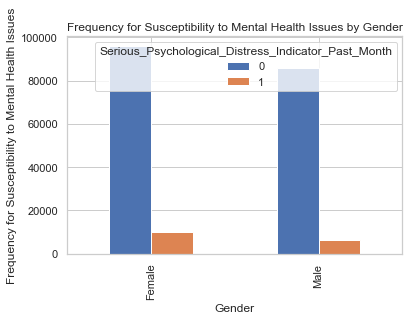

In [31]:
%matplotlib inline
pd.crosstab(df.Gender,df.Serious_Psychological_Distress_Indicator_Past_Month).plot(kind='bar')
plt.title('Frequency for Susceptibility to Mental Health Issues by Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency for Susceptibility to Mental Health Issues')
plt.savefig('outcome_gender')

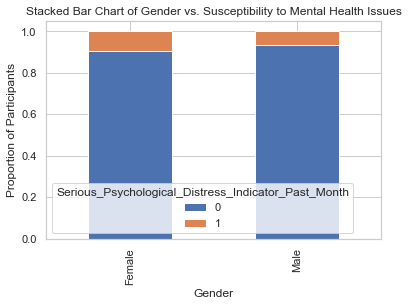

In [32]:
table=pd.crosstab(df.Gender,df.Serious_Psychological_Distress_Indicator_Past_Month)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs. Susceptibility to Mental Health Issues')
plt.xlabel('Gender')
plt.ylabel('Proportion of Participants')
plt.savefig('outcome_gender_stacked')

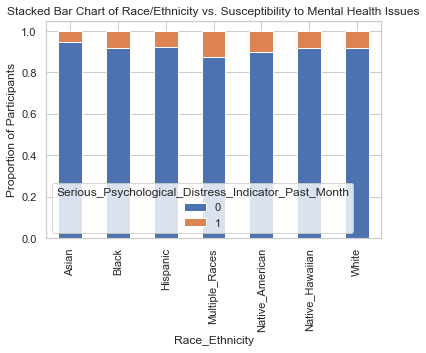

In [33]:
table=pd.crosstab(df.Race_Ethnicity,df.Serious_Psychological_Distress_Indicator_Past_Month)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Race/Ethnicity vs. Susceptibility to Mental Health Issues')
plt.xlabel('Race_Ethnicity')
plt.ylabel('Proportion of Participants')
plt.savefig('outcome_race_stacked')

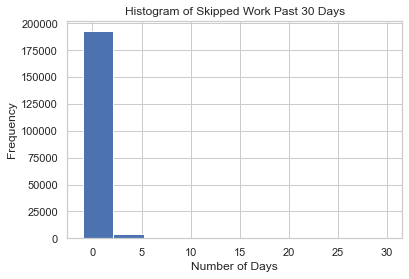

In [34]:
df.Num_Days_Skipped_Work_Past_30_Days.hist()
plt.title('Histogram of Skipped Work Past 30 Days')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.savefig('num_skipped_work_30days')

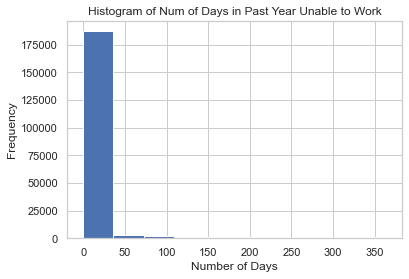

In [35]:
df.Num_Days_Past_Year_Unable_To_Work.hist()
plt.title('Histogram of Num of Days in Past Year Unable to Work')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.savefig('num_unable_to_work_past_year')

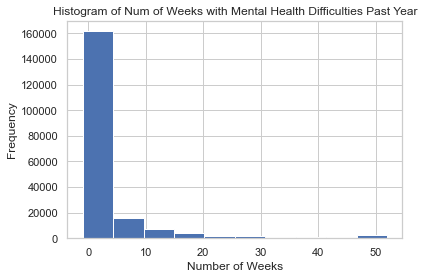

In [36]:
df.Num_Weeks_Mental_Health_Difficulties.hist()
plt.title('Histogram of Num of Weeks with Mental Health Difficulties Past Year')
plt.xlabel('Number of Weeks')
plt.ylabel('Frequency')
plt.savefig('num_weeks_with_mentalhealthdifficulties')

Race/Ethnicity seems a good predictor of the outcome variable

# Bivariate Analysis

## Overview of the Chi-Square Test of Independence

The Chi-square test of association evaluates relationships between categorical variables. Like any statistical hypothesis test, the Chi-square test has both a null hypothesis and an alternative hypothesis.

* Null hypothesis: There are no relationships between the categorical variables. If you know the value of one variable, it does not help you predict the value of another variable.
* Alternative hypothesis: There are relationships between the categorical variables. Knowing the value of one variable does help you predict the value of another variable.

In [135]:
# df_contingency_table = pd.crosstab(index=df["PDEN10"], columns=df["Serious_Psychological_Distress_Indicator_Past_Month"], normalize="columns")*100
# df_contingency_table
pd.crosstab(index=df["PDEN10"], columns=df["Serious_Psychological_Distress_Indicator_Past_Month"])

Serious_Psychological_Distress_Indicator_Past_Month,0,1
PDEN10,,
1_Mil_Or_More,84317,7017
Less_than_1_Mil,97188,9061


In [136]:
ALPHA001 = 0.01

In [137]:
observed_values = pd.crosstab(df.Serious_Psychological_Distress_Indicator_Past_Month, df.PDEN10).values
chi2, p, dof, expected_values = chi2_contingency(observed_values)
chi2, p, expected_values

(46.83285584821233,
 7.730642449557397e-12,
 array([[83901.84211192, 97603.15788808],
        [ 7432.15788808,  8645.84211192]]))

In [138]:
observed_values

array([[84317, 97188],
       [ 7017,  9061]])

In [139]:
outcome = 'Serious_Psychological_Distress_Indicator_Past_Month'
indicator = 'Population Density Type'

if p <= ALPHA001:
    print(f'Rejected H0 under significance level {ALPHA001}, {outcome} & {indicator} are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA001} {outcome} & {indicator} are independent.')

Rejected H0 under significance level 0.01, Serious_Psychological_Distress_Indicator_Past_Month & Population Density Type are dependent.


In [157]:
res = sm.Logit(y, df.PDEN10).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.309879
         Iterations 7
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197582
Method:                                                            MLE   Df Model:                            0
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                -0.09843
Time:                                                         16:41:15   Log-Likelihood:                -61227.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                       nan
  

In [158]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%','Odds Ratio']
print(np.exp(conf))

              5%       95%  Odds Ratio
PDEN10  0.209802  0.214548    0.212161


# Create Dummy Variables

In [47]:
cat_cols = ['Treatment_Type_Past_Year', 'Gender', 'Age_Category_Six_Levels', 'Race_Ethnicity', 
            'Education_Category', 'Overall_Health','Adult_Employment_Status', 
            'Total_Income_Family_Recode', 'Poverty_Level', 
            'County_Metro_NonMetro_Status', 'PDEN10']
for col in cat_cols:
    cat_list='col'+'_'+col
    cat_list = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df1=df.join(cat_list)
    df=df1
    
data_vars=df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_cols]

In [48]:
df_final = df[to_keep]
df_final.columns.values

array(['Year', 'Inpatient_Past_Year', 'Outpatient_Past_Year',
       'Prescription_Treatment_Past_Year', 'Any_Treatment_Past_Year',
       'Perceived_Unmet_Need', 'Received_Treatment_At_Clinic_Or_Center',
       'Received_Treatment_At_Private_Therapist',
       'Received_Treatment_At_NonClinic_Doctor',
       'Received_Treatment_At_Medical_Clinic',
       'Received_Treatment_At_Day_Hospital',
       'Received_Treatment_At_School', 'Received_Treatment_Other',
       'Self_Paid', 'Non_Household_Member_Paid',
       'Private_Health_Insurance_Paid', 'Medicare_Paid', 'Medicaid_Paid',
       'Rehab_Paid', 'Employer_Paid', 'Military_Paid',
       'Other_Public_Source_Paid', 'Other_Private_Source_Paid',
       'Nobody_Paid', 'No_Treatment_Could_Not_Afford',
       'No_Treatment_Feared_Neighbors_Opinion',
       'No_Treatment_Feared_Effect_On_Job',
       'No_Treatment_Insurance_Not_Covered',
       'No_Treatment_Insurance_Not_Covered_Enough',
       'No_Treatment_Where_To_Go',
       'No_Treat

Over-sampling using SMOTE (Synthetic Minority Oversampling Technique). At a high level, SMOTE:
* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [49]:
df_final.shape

(197583, 113)

In [50]:
X = df_final.loc[:, df_final.columns != 'Serious_Psychological_Distress_Indicator_Past_Month']
y = df_final.loc[:, df_final.columns == 'Serious_Psychological_Distress_Indicator_Past_Month']

In [51]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
columns = X_train.columns

os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Serious_Psychological_Distress_Indicator_Past_Month'])

# Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of not susceptible to MH issues oversampled data",len(os_data_y[os_data_y['Serious_Psychological_Distress_Indicator_Past_Month']==0]))
print("Number of susceptible to MH issues",len(os_data_y[os_data_y['Serious_Psychological_Distress_Indicator_Past_Month']==1]))
print("Proportion of not susceptible to MH issues data in oversampled data is ",len(os_data_y[os_data_y['Serious_Psychological_Distress_Indicator_Past_Month']==0])/len(os_data_X))
print("Proportion of susceptible to MH issues in oversampled data is ",len(os_data_y[os_data_y['Serious_Psychological_Distress_Indicator_Past_Month']==1])/len(os_data_X))

Length of oversampled data is  243196
Number of not susceptible to MH issues oversampled data 121598
Number of susceptible to MH issues 121598
Proportion of not susceptible to MH issues data in oversampled data is  0.5
Proportion of susceptible to MH issues in oversampled data is  0.5


# Recursive Feature Elimination

In [53]:
df_final_vars = df_final.columns.values.tolist()
y=['Serious_Psychological_Distress_Indicator_Past_Month']
X=[i for i in df_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe_20 = RFE(logreg, 20)
rfe_20 = rfe_20.fit(os_data_X, os_data_y.values.ravel())

# print(rfe_20.support_)
# print(rfe_20.ranking_)

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (stat

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [54]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

feature_index = []
features = []
column_index(X_train, X_train.columns.values)

for num, i in enumerate(rfe_20.get_support(), start=0):
    if i == True:
        feature_index.append(str(num))

for num, i in enumerate(X_train.columns.values, start=0):
    if str(num) in feature_index:
        features.append(X_train.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index)))
print("Features Indexes: \n{}\n".format(feature_index))
print("Feature Names: \n{}".format(features))

# 'Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Inp_Outp_PrescMed', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown', 'Race_Ethnicity_Black', 'Race_Ethnicity_Hispanic', 'Race_Ethnicity_Multiple_Races', 'Race_Ethnicity_Native_American', 'Race_Ethnicity_White', 'Adult_Employment_Status_Employed_PartTime', 'Poverty_Level_In_Poverty', 'Poverty_Level_More_than_2x_Poverty', 'Poverty_Level_Up_to_2x_Poverty'

Features Selected: 20

Features Indexes: 
['1', '43', '48', '49', '50', '75', '77', '78', '79', '80', '81', '87', '88', '89', '90', '92', '100', '106', '107', '108']

Feature Names: 
['Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Inp_Outp_PrescMed', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown', 'Race_Ethnicity_Black', 'Race_Ethnicity_Hispanic', 'Race_Ethnicity_Multiple_Races', 'Race_Ethnicity_Native_American', 'Race_Ethnicity_White', 'Adult_Employment_Status_Employed_PartTime', 'Poverty_Level_In_Poverty', 'Poverty_Level_More_than_2x_Poverty', 'Poverty_Level_Up_to_2x_Poverty']


In [55]:
df_final_vars = df_final.columns.values.tolist()
y=['Serious_Psychological_Distress_Indicator_Past_Month']
X=[i for i in df_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe_10 = RFE(logreg, 10)
rfe_10 = rfe_10.fit(os_data_X, os_data_y.values.ravel())
# print(rfe_10.support_)
# print(rfe_10.ranking_)

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (stat

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

In [56]:
feature_index = []
features = []
column_index(X_train, X_train.columns.values)

for num, i in enumerate(rfe_10.get_support(), start=0):
    if i == True:
        feature_index.append(str(num))

for num, i in enumerate(X_train.columns.values, start=0):
    if str(num) in feature_index:
        features.append(X_train.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index)))
print("Features Indexes: \n{}\n".format(feature_index))
print("Feature Names: \n{}".format(features))

# 'Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown'

Features Selected: 10

Features Indexes: 
['1', '43', '48', '49', '50', '77', '78', '79', '80', '81']

Feature Names: 
['Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown']


# Forward selection

In [57]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(),
          k_features=10,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 0)

sfs.fit(os_data_X, os_data_y)
sfs.k_feature_names_  

# ('Year',
#  'Perceived_Unmet_Need',
#  'Received_Treatment_At_Day_Hospital',
#  'Self_Paid',
#  'Private_Health_Insurance_Paid',
#  'Worst_Psychological_Distress_Level',
#  'Num_Days_Skipped_Work_Past_30_Days',
#  'Treatment_Type_Past_Year_Inpatient_Only',
#  'Race_Ethnicity_Native_American',
#  'Overall_Health_Unknown')

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL 

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expe

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

('Year',
 'Perceived_Unmet_Need',
 'Received_Treatment_At_Day_Hospital',
 'Self_Paid',
 'Private_Health_Insurance_Paid',
 'Worst_Psychological_Distress_Level',
 'Num_Days_Skipped_Work_Past_30_Days',
 'Treatment_Type_Past_Year_Inpatient_Only',
 'Race_Ethnicity_Native_American',
 'Overall_Health_Unknown')

# X's from Recursive Feature Elimination (k=10/20), Forward (k=10), 

**Going to run logistic regressions on all these different sets of features**

In [159]:
# Control Variables + Exposure variable of interest
control_vars = ['Covered_By_Any_Health_Insurance_Imputation_Revised',
               'Gender_Male', 'Age_Category_Six_Levels_26-34', 'Age_Category_Six_Levels_35-49',
               'Age_Category_Six_Levels_50-64',
               'Age_Category_Six_Levels_65_And_Above', 'Race_Ethnicity_Black',
               'Race_Ethnicity_Hispanic', 'Race_Ethnicity_Multiple_Races',
               'Race_Ethnicity_Native_American', 'Race_Ethnicity_Native_Hawaiian',
               'Race_Ethnicity_White', 'Education_Category_HS_Grad',
               'Education_Category_Less_than_HS',
               'Education_Category_Some_College_Assoc',
               'Overall_Health_Fair_Poor', 'Overall_Health_Good',
               'Overall_Health_Unknown', 'Overall_Health_Very_Good',
               'Adult_Employment_Status_Employed_PartTime',
               'Adult_Employment_Status_Other',
               'Adult_Employment_Status_Unemployed',
               'Total_Income_Family_Recode_20000orLesser',
               'Total_Income_Family_Recode_50000-75000',
               'Total_Income_Family_Recode_75000orMore', 
               'PDEN10_Less_than_1_Mil']

In [162]:
# add sociodemographics variables: Gender, Age, Race/Ethnicity, Education, Household Income
# and add our independent variable of interest: PDEN10 
cols_20 = ['Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Inp_Outp_PrescMed', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown', 'Race_Ethnicity_Black', 'Race_Ethnicity_Hispanic', 'Race_Ethnicity_Multiple_Races', 'Race_Ethnicity_Native_American', 'Race_Ethnicity_White', 'Adult_Employment_Status_Employed_PartTime', 'Poverty_Level_In_Poverty', 'Poverty_Level_More_than_2x_Poverty', 'Poverty_Level_Up_to_2x_Poverty'] 
cols_10 = ['Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Moderate_Mental_Illness_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Low_Or_Moderate_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Outpatient_Only', 'Treatment_Type_Past_Year_Outpatient_PrescMed', 'Treatment_Type_Past_Year_PrescMed_Only', 'Treatment_Type_Past_Year_Skipped', 'Treatment_Type_Past_Year_Unknown']
cols_forward = ['Year',  'Perceived_Unmet_Need', 'Received_Treatment_At_Day_Hospital', 'Self_Paid', 'Private_Health_Insurance_Paid', 'Worst_Psychological_Distress_Level', 'Num_Days_Skipped_Work_Past_30_Days', 'Treatment_Type_Past_Year_Inpatient_Only', 'Race_Ethnicity_Native_American', 'Overall_Health_Unknown']

X_20 = df_final[cols_20 + control_vars]
X_10 = df_final[cols_10 + control_vars]
X_forward = df_final[cols_forward + control_vars]
y = df_final['Serious_Psychological_Distress_Indicator_Past_Month']

# Multicollinearity

**Multicollinearity** (or collinearity) occurs when one independent variable in a regression model is linearly correlated with another independent variable.

**Problems That Arise From Multicollinearity**

1. The fitted regression coefficients (beta hat) will change substantially if one of the values of one of the x variables is changed only a bit.

2. The variance of the estimated coefficients will be inflated, which means that it will be hard to detect statistical significance. Furthermore, it’s possible that the F statistic is significant but the individual t statistics are not.

3. Ultimately, multicollinearity makes prediction less accurate. For a given model, the underlying assumption is that the relationships among the predicting variables, as well as their relationship with the target variable, will be the same. However, when multicollinearity is present, this is less likely to be the case.

In [163]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

In [172]:
mosthighlycorrelated(X_10, 10)

,FirstVariable,SecondVariable,Correlation
0,Mild_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_...,0.771189
1,Treatment_Type_Past_Year_PrescMed_Only,Treatment_Type_Past_Year_Skipped,-0.605772
2,Moderate_Mental_Illness_Indicator_Past_Year,Low_Or_Moderate_Mental_Illness_Indicator_Past_...,0.567662
3,Race_Ethnicity_Hispanic,Race_Ethnicity_White,-0.561718
4,Treatment_Type_Past_Year_Outpatient_PrescMed,Treatment_Type_Past_Year_Skipped,-0.523462
5,Overall_Health_Good,Overall_Health_Very_Good,-0.483082
6,Race_Ethnicity_Black,Race_Ethnicity_White,-0.461997
7,Education_Category_HS_Grad,Education_Category_Some_College_Assoc,-0.419391
8,Serious_Psychological_Distress_Indicator_Past_...,Low_Or_Moderate_Mental_Illness_Indicator_Past_...,0.403860
9,Treatment_Type_Past_Year_Outpatient_Only,Treatment_Type_Past_Year_Skipped,-0.377306


# Logistic Multivariate Regression (Multivariate Analysis)

**Logistic Regression assumptions:**

* The linear relationship between the continuous independent variables and log odds of the dependent variable
* No multicollinearity among the independent variables. Multicollinearity can be tested using the Variance Inflation Factor (VIF).
* No influential outliers
* Independence of errors (residuals) or no significant autocorrelation. The residuals should not be correlated with each other. This can be tested using the Durbin-Watson test.
* The sample size should be large (at least 50 observations per independent variables are recommended)

## Fit Logistic Regression 

#### Model with X_20

In [168]:
res = sm.Logit(y, X_20).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.101577
         Iterations 13
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197544
Method:                                                            MLE   Df Model:                           38
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                  0.6399
Time:                                                         19:03:19   Log-Likelihood:                -20070.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
 

In [ ]:
# params = res.params
# conf = res.conf_int()
# conf['Odds Ratio'] = params
# conf.columns = ['5%', '95%','Odds Ratio']
# print(np.exp(conf))

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_20, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print('Accuracy for X_20: {}'.format(score))

Accuracy for X_20: 0.9444657454411607


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [184]:
X_19 = X_20.drop(['Serious_Psychological_Distress_Indicator_Past_Year'], axis=1)

In [187]:
res = sm.Logit(y, X_19).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.221489
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197543
Method:                                                            MLE   Df Model:                           39
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                  0.2149
Time:                                                         19:22:22   Log-Likelihood:                -43762.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X_19, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print('Accuracy for X_20: {}'.format(score))

Accuracy for X_20: 0.9166449396500161


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model with X_10

In [176]:
res = sm.Logit(y, X_10).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.101983
         Iterations 13
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197549
Method:                                                            MLE   Df Model:                           33
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                  0.6385
Time:                                                         19:06:52   Log-Likelihood:                -20150.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
 

In [ ]:
# params = res.params
# conf = res.conf_int()
# conf['Odds Ratio'] = params
# conf.columns = ['5%', '95%','Odds Ratio']
# print(np.exp(conf))

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_10, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print('Accuracy for X_10: {}'.format(score))

Accuracy for X_10: 0.9442663681118967


In [188]:
X_9 = X_10.drop(['Serious_Psychological_Distress_Indicator_Past_Year'], axis=1)

In [189]:
res = sm.Logit(y, X_9).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.221592
         Iterations 8
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197550
Method:                                                            MLE   Df Model:                           32
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                  0.2145
Time:                                                         19:24:02   Log-Likelihood:                -43783.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_10, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print('Accuracy for X_10: {}'.format(score))

Accuracy for X_10: 0.9442663681118967


/Users/chiufengyap/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model with X_forward

In [180]:
res = sm.Logit(y, X_forward).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.118913
         Iterations 9
                                            Logit Regression Results                                           
Dep. Variable:     Serious_Psychological_Distress_Indicator_Past_Month   No. Observations:               197583
Model:                                                           Logit   Df Residuals:                   197550
Method:                                                            MLE   Df Model:                           32
Date:                                                 Fri, 22 Oct 2021   Pseudo R-squ.:                  0.5785
Time:                                                         19:07:30   Log-Likelihood:                -23495.
converged:                                                        True   LL-Null:                       -55740.
Covariance Type:                                             nonrobust   LLR p-value:                     0.000
  

In [ ]:
# params = res.params
# conf = res.conf_int()
# conf['Odds Ratio'] = params
# conf.columns = ['5%', '95%','Odds Ratio']
# print(np.exp(conf))

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X_forward, y, test_size=0.33, random_state=42)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_test, y_test)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print('Accuracy for X_forward: {}'.format(score))

Accuracy for X_forward: 0.9431927978773983


# Best Model

**R^2 score:** 0.6218

**Test accuracy:** 0.9351

**Number of features:** 12

**Features included:** 'Inpatient_Past_Year', 'Serious_Psychological_Distress_Indicator_Past_Year', 'Mild_Mental_Illness_Indicator_Past_Year', 'Treatment_Type_Past_Year_Inp_Outp_PrescMed',
'Treatment_Type_Past_Year_Outpatient_Only',    'Treatment_Type_Past_Year_Outpatient_PrescMed',
‘Treatment_Type_Past_Year_PrescMed_Only',
‘Treatment_Type_Past_Year_Skipped', ‘Treatment_Type_Past_Year_Unknown',
‘Race_Ethnicity_White', 'Adult_Employment_Status_Employed_PartTime',
'Poverty_Level_In_Poverty', ‘Poverty_Level_More_than_2x_Poverty',
‘Poverty_Level_Up_to_2x_Poverty', 'PDEN10_Less_than_1_Mil'